Main question: Home vs away's effect on performance. (Does having a race in your country affect performance?)

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

In [213]:
races            = pd.read_csv("./dataset/races.csv")
circuits         = pd.read_csv("./dataset/circuits.csv")
constructors     = pd.read_csv("./dataset/constructors.csv")
drivers          = pd.read_csv("./dataset/drivers.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")
demonyms         = pd.read_csv("./dataset/demonyms.csv")

In [214]:
# Alfonso Thiele had an American-Italian citizenship, but he mainly raced for an italian team
# The same applies for Alessandro de Tomaso.
alfonso_index = drivers[(drivers['forename'] == 'Alfonso') & (drivers['surname'] == 'Thiele')].index
alessandro_index = drivers[(drivers['forename'] == 'Alessandro') & (drivers['surname'] == 'de Tomaso')].index

drivers.loc[alfonso_index, 'nationality'] = 'Italian'
drivers.loc[alessandro_index, 'nationality'] = 'Italian'

# There are multiple east german drivers
drivers[drivers['nationality'] == 'East German'] = 'German'

In [215]:
def lookup_country(nationality: str) -> str:
    match = demonyms[demonyms['nationality'] == nationality].iloc[0]['country']
    return match

display(drivers['nationality'])
drivers['country'] = drivers['nationality'].apply(lookup_country)

assert not drivers['country'].hasnans

0         British
1          German
2          German
3         Spanish
4         Finnish
          ...    
852        German
853       Chinese
854         Dutch
855    Australian
856      American
Name: nationality, Length: 857, dtype: object

In [216]:
races.rename(columns={'name':'race_name'}, inplace=True)
races = races[['raceId', 'year', 'race_name', 'circuitId']]

circuits.rename(columns={'name':'circuit_name'}, inplace=True)
circuits.drop(columns=['url', 'lat', 'lng', 'alt', 'location'], inplace=True)

races_circuits = pd.merge(races, circuits, on='circuitId', how='left')

display(races_circuits)

,raceId,year,race_name,circuitId,circuitRef,circuit_name,country
0,1,2009,Australian Grand Prix,1,albert_park,Albert Park Grand Prix Circuit,Australia
1,2,2009,Malaysian Grand Prix,2,sepang,Sepang International Circuit,Malaysia
2,3,2009,Chinese Grand Prix,17,shanghai,Shanghai International Circuit,China
3,4,2009,Bahrain Grand Prix,3,bahrain,Bahrain International Circuit,Bahrain
4,5,2009,Spanish Grand Prix,4,catalunya,Circuit de Barcelona-Catalunya,Spain
...,...,...,...,...,...,...,...
1097,1116,2023,United States Grand Prix,69,americas,Circuit of the Americas,USA
1098,1117,2023,Mexico City Grand Prix,32,rodriguez,Autódromo Hermanos Rodríguez,Mexico
1099,1118,2023,São Paulo Grand Prix,18,interlagos,Autódromo José Carlos Pace,Brazil
1100,1119,2023,Las Vegas Grand Prix,80,vegas,Las Vegas Strip Street Circuit,United States


In [217]:
drivers = drivers[['driverId', 'country']]
drivers.rename(columns={'country': 'driver_country'}, inplace=True)

driver_standings = driver_standings[['raceId', 'driverId', 'position', 'points']]
races = races[['raceId', 'circuitId', 'year']]

circuits = circuits[['circuitId', 'country']]
circuits.rename(columns={'country': 'circuit_country'}, inplace=True)


# join the dataframes
driver_results = pd.merge(drivers, driver_standings, on='driverId')
driver_race_results = pd.merge(driver_results, races, on='raceId')
driver_circuit_results = pd.merge(driver_race_results, circuits, on='circuitId')

display(driver_circuit_results)

df = driver_circuit_results

# Small note, here we use the data of drivers who have raced in their home as
# this is the smaller group vs drivers who have raced elsewhere. You can imagine
# this as a diagram where racers who have raced in their home country is a
# subset of all racers.
df['driver_at_home'] = df['driver_country'] == df['circuit_country']
display(df['driver_at_home'].value_counts())

,driverId,driver_country,raceId,position,points,circuitId,year,circuit_country
0,1,United Kingdom,18,1,10.0,1,2008,Australia
1,2,Germany,18,2,8.0,1,2008,Australia
2,3,Germany,18,3,6.0,1,2008,Australia
3,4,Spain,18,4,5.0,1,2008,Australia
4,5,Finland,18,5,4.0,1,2008,Australia
...,...,...,...,...,...,...,...,...
33882,725,United Kingdom,825,17,0.0,66,1951,Switzerland
33883,741,France,825,10,0.0,66,1951,Switzerland
33884,763,Italy,825,4,3.0,66,1951,Switzerland
33885,764,France,825,14,0.0,66,1951,Switzerland


driver_at_home
False    32299
True      1588
Name: count, dtype: int64

In [221]:
def sort_points(x: pd.DataFrame) -> pd.Series:
    return x.sort_values() if x.Name == 'points' else x

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    t = df.groupby(['year', 'driverId']).apply(lambda x: x.sort_values('raceId', ascending=True))['points'].diff().fillna(0)

    display()
    # display(df.sort_values(['driverId', 'raceId']))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/frame.py", line 11615, in _reindex_for_setitem
    reindexed_value = value.reindex(index)._values
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/series.py", line 4914, in reindex
    return super().reindex(
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 5360, in reindex
    return self._reindex_axes(
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 5375, in _reindex_axes
    new_index, indexer = ax.reindex(
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 4278, in reindex
    target = self._wrap_reindex_result(target, indexer, preserve_names)
  File "/home/tarek/.local/lib/python3.10/site-packages/pandas/core/indexes/multi.py", line 2490, in _wrap_reindex_result
    target = MultiIndex.from_tuples(target)
  File "/home/tarek/.local/lib/python3.10/s

In [160]:
df.sort_values('points', ascending=False)

,driverId,driver_country,raceId,position,points,circuitId,year,circuit_country,driver_at_home
19782,830,Netherlands,1096,1,454.0,24,2022,UAE,False
15556,830,Netherlands,1095,1,429.0,18,2022,Brazil,False
21596,830,Netherlands,1094,1,416.0,32,2022,Mexico,False
19709,1,United Kingdom,1030,1,413.0,24,2019,UAE,False
19689,1,United Kingdom,1009,1,408.0,24,2018,UAE,False
...,...,...,...,...,...,...,...,...,...
18560,675,United States,804,45,0.0,20,1954,Germany,False
18559,674,United States,804,33,0.0,20,1954,Germany,False
18557,672,Argentina,804,67,0.0,20,1954,Germany,False
18556,671,France,804,65,0.0,20,1954,Germany,False


In [ ]:
df = df[df['points'] > 30]

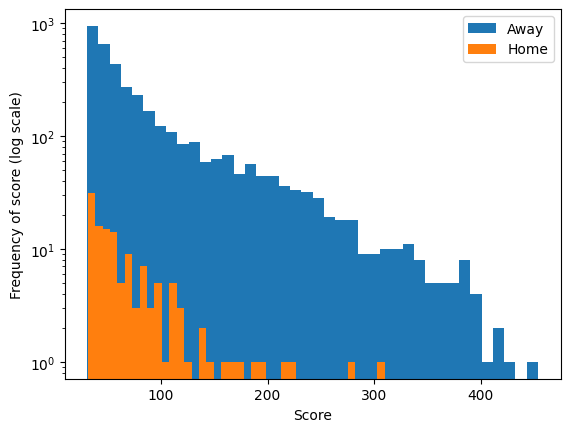

In [150]:
from math import log

home_points = df[df['driver_at_home'] == True]['points']
away_points = df[df['driver_at_home'] != True]['points']

plt.hist(away_points, bins=40, histtype='stepfilled', log=True)
plt.hist(home_points, bins=40, histtype='stepfilled', log=True)

plt.legend(['Away', 'Home'])
plt.ylabel('Frequency of score (log scale)')
plt.xlabel('Score')
plt.show()

In [151]:
g_country = df.groupby(['driver_country', 'driver_at_home']).aggregate({'points': 'mean'}).sort_values('points', ascending=False)

g_country.head(100)

points
driver_country driver_at_home            
Netherlands    True            267.250000
               False           151.790698
 Monaco        False           124.226667
Mexico         True            112.857143
United Kingdom False           104.129275
Australia      False           100.798246
Finland        False            98.311558
Germany        False            98.246130
Spain          False            92.801852
Brazil         True             86.000000
Mexico         False            83.819672
Germany        True             71.947368
Poland         False            69.235294
Spain          True             65.916667
Thailand       False            65.238095
Brazil         False            56.014006
Russia         True             54.500000
France         False            53.538983
Canada         False            52.000000
Colombia       False            48.575758
Austria        True             46.928571
Denmark        False            46.000000
Austria        False            44.712500
Russia         False            44.437500
United States  False            43.869565
Italy          False            41.635802
Sweden         False            41.437500
South Africa   False            41.281250
Italy          True             41.227273
Switzerland    False            41.222222
France         True             40.833333
Japan          True             40.500000
               False            40.400000
Venezuela      False            38.666667
Canada         True             38.000000
Argentina      False            37.980455
New Zealand    False            37.500000
Belgium        False            34.125000